In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.7948704, -0.6067793,  0.4894053], dtype=float32)

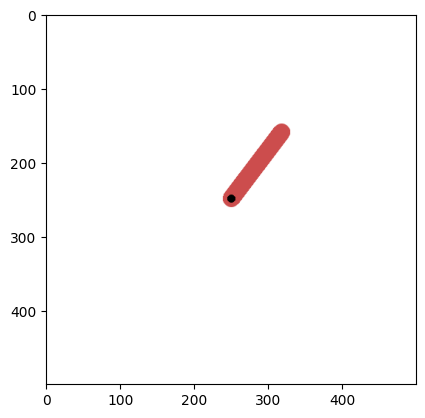

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch


#DuelingDQN和其他DQN模型不同的点,它使用的是不同的模型结构
class VAnet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
        )

        self.fc_A = torch.nn.Linear(128, 11)
        self.fc_V = torch.nn.Linear(128, 1)

    def forward(self, x):
        #[5, 11] -> [5, 128] -> [5, 11]
        A = self.fc_A(self.fc(x))

        #[5, 11] -> [5, 128] -> [5, 1]
        V = self.fc_V(self.fc(x))

        #[5, 11] -> [5] -> [5, 1]
        A_mean = A.mean(dim=1).reshape(-1, 1)

        #[5, 11] - [5, 1] = [5, 11]
        A -= A_mean

        #Q值由V值和A值计算得到
        #[5, 11] + [5, 1] = [5, 11]
        Q = A + V

        return Q


VAnet()(torch.randn(5, 3)).shape

torch.Size([5, 11])

In [4]:
import torch

#计算动作的模型,也是真正要用的模型
model = VAnet()

#经验网络,用于评估一个状态的分数
next_model = VAnet()

#把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(VAnet(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=128, bias=True)
     (1): ReLU()
   )
   (fc_A): Linear(in_features=128, out_features=11, bias=True)
   (fc_V): Linear(in_features=128, out_features=1, bias=True)
 ),
 VAnet(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=128, bias=True)
     (1): ReLU()
   )
   (fc_A): Linear(in_features=128, out_features=11, bias=True)
   (fc_V): Linear(in_features=128, out_features=1, bias=True)
 ))

In [5]:
import random


def get_action(state):
    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    #离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(3, -0.8)

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 5000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((200, 0), 200)

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

/tmp/ipykernel_1456/1416897299.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[ 0.9759,  0.2183, -0.8936],
         [-0.4725,  0.8813, -3.0240],
         [-0.1743, -0.9847,  0.6815],
         [ 0.9895,  0.1446,  0.0487],
         [ 0.9373,  0.3485,  4.5409],
         [-0.9973, -0.0729, -5.6901],
         [ 0.7743,  0.6328,  5.1138],
         [-0.8478,  0.5303,  4.0918],
         [ 0.8918,  0.4524, -1.6551],
         [-0.2661, -0.9640,  7.2406],
         [-0.3598,  0.9330, -2.4830],
         [ 0.7067, -0.7075,  5.0712],
         [-0.9910, -0.1336,  8.0000],
         [-0.8945, -0.4470,  8.0000],
         [-0.3082, -0.9513,  7.2930],
         [-0.4207,  0.9072,  8.0000],
         [-0.1909,  0.9816,  5.9905],
         [-0.9967, -0.0811, -4.1083],
         [ 0.7361,  0.6769, -2.2856],
         [-0.4541,  0.8910,  2.4770],
         [-0.4730, -0.8811,  3.0176],
         [ 0.9875,  0.1576,  4.3611],
         [ 0.8510, -0.5252,  4.6605],
         [-0.2706, -0.9627,  1.8972],
         [ 0.7631, -0.6463,  4.9572],
         [-0.9439,  0.3302,  8.0000],
         [ 0

In [8]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 3] -> [b, 11]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[0.2186],
        [1.0698],
        [0.3330],
        [0.3346],
        [1.6194],
        [1.4954],
        [1.8757],
        [1.6286],
        [0.0499],
        [2.4810],
        [0.9849],
        [1.8553],
        [2.6182],
        [2.6429],
        [2.4936],
        [3.1149],
        [2.3909],
        [1.1692],
        [0.5405],
        [1.3310],
        [0.8825],
        [1.5797],
        [1.7221],
        [0.5553],
        [1.8204],
        [2.8339],
        [1.2302],
        [1.0705],
        [0.8048],
        [0.8547],
        [3.1013],
        [1.5785],
        [0.2799],
        [2.5150],
        [2.5211],
        [2.6108],
        [1.2935],
        [1.4403],
        [1.3595],
        [0.6939],
        [1.5672],
        [1.6380],
        [0.2888],
        [1.4279],
        [0.2320],
        [0.8344],
        [1.5701],
        [0.7657],
        [0.8718],
        [0.8129],
        [3.0086],
        [0.6486],
        [0.3951],
        [2.8619],
        [0.6737],
        [1

In [9]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)

    #取所有动作中分数最大的
    #[b, 11] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[  0.0989],
        [ -4.2057],
        [ -2.8124],
        [  0.3336],
        [ -0.4502],
        [-11.1096],
        [ -0.9207],
        [ -6.7393],
        [ -0.2133],
        [ -6.3599],
        [ -3.5263],
        [ -1.5024],
        [-12.8474],
        [-11.0097],
        [ -6.5850],
        [ -7.4731],
        [ -4.0707],
        [ -9.8589],
        [ -0.6378],
        [ -3.3438],
        [ -4.4678],
        [ -0.3240],
        [ -0.8849],
        [ -3.3451],
        [ -1.2864],
        [-11.7006],
        [ -0.1756],
        [  0.1426],
        [  0.4434],
        [ -6.3546],
        [ -7.7860],
        [-10.5221],
        [ -4.4468],
        [ -2.8167],
        [ -7.0503],
        [ -8.6312],
        [ -9.3022],
        [ -8.5745],
        [ -8.5947],
        [ -5.1716],
        [ -7.4085],
        [ -8.2715],
        [ -2.7818],
        [ -0.6612],
        [  0.1618],
        [ -2.2332],
        [ -0.3004],
        [ -2.3261],
        [ -6.0247],
        [ -3.1003],


In [10]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        _, action_continuous = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1782.7036413962624

In [11]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_count, drop_count = update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            test_result = sum([test(play=False) for _ in range(20)]) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 400 200 0 -1549.6536307654428
20 4400 200 0 -774.4212962756064
40 5000 200 200 -544.4996603817052
60 5000 200 200 -257.0068187439457
80 5000 200 200 -548.199814393714
100 5000 200 200 -335.9420079992984
120 5000 200 200 -168.05497405405734
140 5000 200 200 -408.53733198713195
160 5000 200 200 -412.63491065532145
180 5000 200 200 -296.082461949791


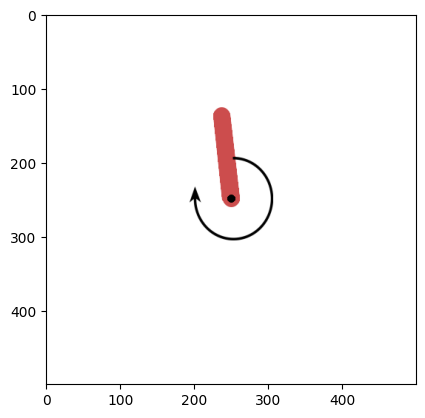

-120.60388566888659

In [12]:
test(play=True)